In [1]:
import pandas_datareader.data as web
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# read data
rgdp_org = web.DataReader('JPNRGDPEXP', 'fred',start = datetime.datetime(1994,1,1),end = datetime.datetime(2020,10,1))

rgdp_df = rgdp_org.copy()
rgdp_df

,JPNRGDPEXP
DATE,
1994-01-01,446278.0
1994-04-01,443805.1
1994-07-01,448938.0
1994-10-01,447131.3
1995-01-01,452082.7
...,...
2019-10-01,548764.6
2020-01-01,545673.1
2020-04-01,500391.2


In [2]:
# plot data function
def plot_data(data_b, data_r, label, title, ylim=None):
    # plot
    if data_b is not None:
        plt.plot(data_b.index, data_b, label=label[0], color="blue")
    if data_r is not None:
        plt.plot(data_r.index, data_r, label=label[1], color="darkorange")

    # title
    plt.title(title)
    
    #lim
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    #setting
    plt.xticks(rotation=90, size='small')
    
    # display
    plt.legend()

    # show
    plt.show()

In [3]:
# log transformation function
def log_transformation(data_y):
    data_l = np.log(data_y)
    return data_l.dropna(how="any")

In [4]:
# convert the index
index = pd.date_range(rgdp_df.index[0], periods=rgdp_df.shape[0], freq="q")
rgdp_df.set_index(index, inplace=True)
type(rgdp_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# call log transformation func
data_l = log_transformation(rgdp_df["JPNRGDPEXP"])
data_l.tail()

2019-12-31    13.215425
2020-03-31    13.209775
2020-06-30    13.123145
2020-09-30    13.174558
2020-12-31    13.202319
Freq: Q-DEC, Name: JPNRGDPEXP, dtype: float64

In [6]:
# Problem 3-1

# search optimal AIC
aic_list = []

for i in range(1,14):
    model = AutoReg(data_l, lags=i, trend="t", old_names=False)
    result = model.fit()
    aic_list.append(result.aic)
    print("index", i, "value:", result.aic)

#optimal AIC
opt_lag =  np.argmin(np.array(aic_list)) +1
    
print("Min AIC lag:", opt_lag)
print("Min AIC:", np.min(aic_list))

index 1 value: -8.499866153046112
index 2 value: -8.47894487705649
index 3 value: -8.452741242397853
index 4 value: -8.461807902857268
index 5 value: -8.43807764470087
index 6 value: -8.414498211306478
index 7 value: -8.386803294074435
index 8 value: -8.35602792950735
index 9 value: -8.33396690003844
index 10 value: -8.310965576883671
index 11 value: -8.282114625740965
index 12 value: -8.281358050518865
index 13 value: -8.249094153545126
Min AIC lag: 1
Min AIC: -8.499866153046112


In [7]:
#predict Y_t
model = AutoReg(data_l, lags=opt_lag, old_names=False)
result = model.fit()
predict_y = model.predict(result.params)

In [8]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

adf_results = adfuller(data_l, maxlag=opt_lag ,autolag=None)
print("stats", adf_results[0])
print("p-value", adf_results[1])
print("used_lags", adf_results[2])

stats -1.9815201148283494
p-value 0.294734200201419
used_lags 1


In [9]:
from sklearn.linear_model import LinearRegression as lr
import datetime

# problem 3-2

time = np.array(range(0, data_l.count())).reshape(-1,1) # time

# linear trend
model = lr()
model.fit(time, data_l)
predict_lr = model.predict(time)

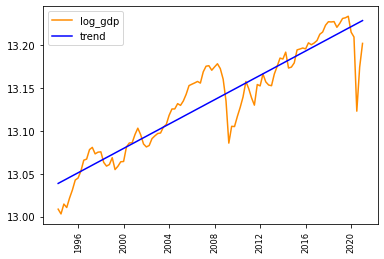

In [10]:
# plot
plt.plot(data_l.index, data_l, label="log_gdp", color="darkorange")
plt.plot(data_l.index, predict_lr, label="trend", color="blue")

#setting
plt.xticks(rotation=90, size='small')
    
# display
plt.legend()

# show
plt.show()

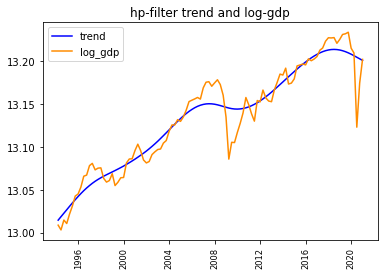

In [11]:
# problem 3-3

# HP filter
cycle, trend = sm.tsa.filters.hpfilter(data_l, 1600)
plot_data(trend, data_l, ['trend', 'log_gdp'], 'hp-filter trend and log-gdp')

In [12]:
# problem 3-5

# AR(12) model
data_ld = data_l.diff(1).dropna(how="any")
lag_num = 12
model = AutoReg(data_ld, lags=lag_num, trend='c', old_names=False)
result = model.fit()
predict_ar = result.predict()

In [13]:
# transform data

sum_beta = sum(result.params[1:lag_num+1]) # sum from beta_1 to beta_12
delta = result.params[0] / (1 - sum_beta) # drift
bn_trend = data_ld.copy() # b-n trend initialized
bn_trend[:] = np.nan # initialized

In [14]:
# B-N decomposition
bn_trend = data_l + (data_ld - delta)*(sum_beta / (1-sum_beta)) 

cycle = data_l - bn_trend

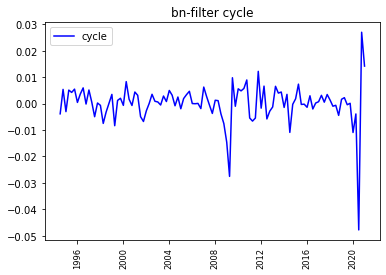

In [15]:
# plot b-n trend and log series
plot_data(cycle, None, ['cycle'], 'bn-filter cycle')

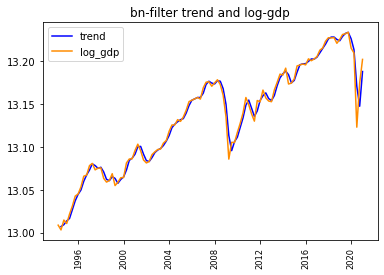

In [16]:
# plot b-n trend and log series
plot_data(bn_trend, data_l, ['trend', 'log_gdp'], 'bn-filter trend and log-gdp')

In [17]:
# Problem 3-6

# calculate RSS
def calc_residuals(X, y):
    # calc_chowstat 
    model = lr()
    model.fit(X, y)
    pred = model.predict(X)
    return sum(np.power(y-pred,2))    

In [18]:
# diff(1)
data_ld = data_l.diff(1).dropna(how='any')
time = np.array(range(0, data_ld.count())).reshape(-1,1)

# restricted RSS
rss_r = calc_residuals(time, data_ld)

q = 1 

start = 19 # 20th period
start_idx = data_ld.index[start]
period = data_ld.index[start:]    

In [19]:
# max-F
max_F = 0
breakp = None # break point

# search sup-Fstatic
for i, t in enumerate(period):
    time1, time2 = data_ld.index[start+i-1], data_ld.index[start+i] # break point
    Y1, Y2 = data_ld[:time1], data_ld[time2:]
    X1 = np.array(range(0, Y1.count())).reshape(-1,1)
    X2 = np.array(range(0, Y2.count())).reshape(-1,1)
    
    rss_1 = calc_residuals(X1, Y1)
    rss_2 = calc_residuals(X2, Y2)
    
    # Chow test
    numerator = (rss_r - (rss_1 + rss_2)) / q
    denominator = rss_r / (data_ld.count() - 2*q)
    
    F = (numerator / denominator)
    
    # update breakpoint
    if max_F < F:
        breakp = [start+i, time1, time2]
        
    max_F = max(max_F, F)

In [20]:
# estimate trend
model_bef = lr()
model_aft = lr()

# time
time_bef = np.array(range(0, data_ld[:breakp[1]].count())).reshape(-1,1)
time_aft = np.array(range(0, data_ld[breakp[2]:].count())).reshape(-1,1)

# estimate
model_bef.fit(time_bef, data_ld[:breakp[1]])
model_aft.fit(time_aft, data_ld[breakp[2]:])

# predict
predict_bef = model_bef.predict(time_bef)
predict_aft = model_aft.predict(time_aft)

print('Before break point trend = ', model_bef.coef_)
print('After break point trend = ', model_aft.coef_)

Before break point trend =  [-2.65397739e-05]
After break point trend =  [0.05719534]


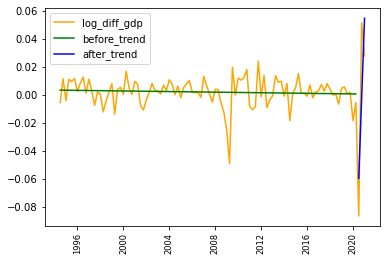

In [21]:
# plot
plt.plot(data_ld.index, data_ld, label="log_diff_gdp", color="orange")
plt.plot(data_ld.index[:breakp[0]], predict_bef, label="before_trend", color="green")
plt.plot(data_ld.index[breakp[0]:], predict_aft, label="after_trend", color="blue")

#setting
plt.xticks(rotation=90, size='small')
    
# display
plt.legend()

# show
plt.show()